In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from textblob import TextBlob
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Загрузка данных из CSV-файла
data = pd.read_csv('data/telegram_messages_sentiment.csv')

# Преобразование столбца 'date' в формат datetime
data['date'] = pd.to_datetime(data['date'])
data['is_question'] = data['message'].apply(lambda x: '?' in str(x))
# Определяем, является ли сообщение постом администратора
data['is_admin_post'] = data['sender_id'].apply(lambda x: x < 0)
data 

,date,sender_id,message,char_count,word_count,has_photo,has_video,has_audio,has_document,has_is_reply,has_is_sticker,sentiment,is_question,is_admin_post
0,2024-06-08 11:22:26,1.438208e+09,Минимум затрат времени на задачу = 40 часов,43,8,False,False,False,False,False,False,3 stars,False,False
1,2024-06-08 11:20:38,1.438208e+09,Идеально - если у Вас есть платёжеспособный за...,178,27,False,False,False,False,False,False,5 stars,False,False
2,2024-06-08 06:06:58,9.545769e+07,Идеально - если есть реальная задача и вы ее п...,62,11,False,False,False,False,False,False,4 stars,False,False
3,2024-06-08 05:46:30,1.702404e+09,"Добрый день коллеги, кто нибудь подскажет с че...",133,19,False,False,False,False,False,False,4 stars,True,False
4,2024-06-07 20:39:55,5.140743e+08,NaN,0,0,False,False,False,False,False,False,neutral,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53933,2018-05-25 18:59:52,3.515917e+08,NaN,0,0,True,False,False,False,False,False,neutral,False,False
53934,2018-05-25 18:59:52,3.515917e+08,"Прикиньте, даже на телефоне сервис работает",43,6,False,False,False,False,False,False,5 stars,False,False
53935,2018-05-25 18:40:02,3.515917e+08,NaN,0,0,False,False,False,True,False,True,neutral,False,False
53936,2018-05-25 18:14:16,4.995597e+08,Хелло,5,1,False,False,False,False,False,False,3 stars,False,False


In [4]:
from datetime import datetime

# Группировка данных по sender_id и вычисление необходимых агрегатов
data['message'].fillna('zero', inplace=True)
user_features = data.groupby('sender_id').agg({
    'message': 'count',
    'char_count': ['mean', 'sum'],
    'word_count': ['mean', 'sum'],
    'has_photo': ['mean', 'sum'],
    'has_video': ['mean', 'sum'],
    'has_audio': ['mean', 'sum'],
    'has_document': ['mean', 'sum'],
    'date': [lambda x: (x.max() - x.min()).days, 'min', 'max'],
    'sentiment': lambda x: x.value_counts().to_dict(),
    'is_question': ['mean', 'sum'],
    'has_is_reply': ['mean', 'sum']
}).reset_index()

# Переименование столбцов для удобства
user_features.columns = [
    'sender_id', 'message_count', 'avg_char_count', 'total_char_count',
    'avg_word_count', 'total_word_count', 'avg_photo', 'total_photo',
    'avg_video', 'total_video', 'avg_audio', 'total_audio',
    'avg_document', 'total_document', 'lifetime_days',
    'first_message_date', 'last_message_date', 'sentiment_counts',
    'avg_is_question', 'total_is_question', 'avg_is_reply', 'total_is_reply'
]

# Определение активности пользователя за последние 3 месяца
current_date = datetime.now()
user_features['is_active'] = user_features['last_message_date'].apply(lambda x: (current_date - x).days <= 90)
user_features['is_active'] = user_features['is_active'].astype(int)

# Добавление столбцов с днем недели и часом
data['day_of_week'] = data['date'].dt.day_name()
data['hour'] = data['date'].dt.hour

# Группировка по sender_id и определение дня недели и часа с наибольшей активностью
most_active_day = data.groupby('sender_id')['day_of_week'].agg(lambda x: x.value_counts().idxmax())
most_active_hour = data.groupby('sender_id')['hour'].agg(lambda x: x.value_counts().idxmax())

# Добавление этих метрик в user_features
user_features = user_features.merge(most_active_day, on='sender_id', how='left')
user_features = user_features.merge(most_active_hour, on='sender_id', how='left')

# Переименование столбцов
user_features.rename(columns={'day_of_week': 'most_active_day', 'hour': 'most_active_hour'}, inplace=True)

# Определение количества сообщений с разными типами настроений
user_features['neutral_messages'] = user_features['sentiment_counts'].apply(lambda x: x.get('neutral', 0))
user_features['1star_messages'] = user_features['sentiment_counts'].apply(lambda x: x.get('1 star', 0))
user_features['2star_messages'] = user_features['sentiment_counts'].apply(lambda x: x.get('2 stars', 0))
user_features['3star_messages'] = user_features['sentiment_counts'].apply(lambda x: x.get('3 stars', 0))
user_features['4star_messages'] = user_features['sentiment_counts'].apply(lambda x: x.get('4 stars', 0))
user_features['5star_messages'] = user_features['sentiment_counts'].apply(lambda x: x.get('5 stars', 0))

# Определение среднего и максимального времени между сообщениями
data['prev_date'] = data.groupby('sender_id')['date'].shift(1)
data['time_diff'] = (data['date'] - data['prev_date']).dt.total_seconds()

avg_time_between_messages = data.groupby('sender_id')['time_diff'].mean()
max_time_between_messages = data.groupby('sender_id')['time_diff'].max()

# # Добавление этих метрик в user_features
# user_features = user_features.merge(avg_time_between_messages, on='sender_id', how='left')
# user_features = user_features.merge(max_time_between_messages, on='sender_id', how='left')
# 
# # Переименование столбцов
# user_features.rename(columns={'time_diff_x': 'avg_time_between_messages', 'time_diff_y': 'max_time_between_messages'}, inplace=True)

# Удаление временного столбца sentiment_counts
user_features.drop(columns=['sentiment_counts','most_active_day'], inplace=True)

# user_features = pd.get_dummies(user_features, columns=['most_active_day'])
user_features


,sender_id,message_count,avg_char_count,total_char_count,avg_word_count,total_word_count,avg_photo,total_photo,avg_video,total_video,...,avg_is_reply,total_is_reply,is_active,most_active_hour,neutral_messages,1star_messages,2star_messages,3star_messages,4star_messages,5star_messages
0,-1.001980e+12,1,1.0,1,1.0,1,0.0,0,0.0,0,...,1.0,1,0,14,0,0,0,0,0,1
1,-1.001740e+12,1,34.0,34,6.0,6,0.0,0,0.0,0,...,1.0,1,0,12,0,0,0,0,0,1
2,-1.001725e+12,2,7.5,15,1.5,3,0.0,0,0.0,0,...,0.5,1,0,15,0,0,0,0,1,1
3,-1.001612e+12,1,117.0,117,17.0,17,0.0,0,0.0,0,...,0.0,0,0,2,0,1,0,0,0,0
4,-1.001462e+12,2,32.0,64,1.5,3,0.0,0,0.0,0,...,1.0,2,0,18,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5023,7.173291e+09,1,0.0,0,0.0,0,0.0,0,0.0,0,...,0.0,0,1,12,1,0,0,0,0,0
5024,7.182824e+09,1,0.0,0,0.0,0,0.0,0,0.0,0,...,0.0,0,0,10,1,0,0,0,0,0
5025,7.187692e+09,1,0.0,0,0.0,0,0.0,0,0.0,0,...,0.0,0,1,17,1,0,0,0,0,0
5026,7.188730e+09,1,0.0,0,0.0,0,0.0,0,0.0,0,...,0.0,0,1,9,1,0,0,0,0,0


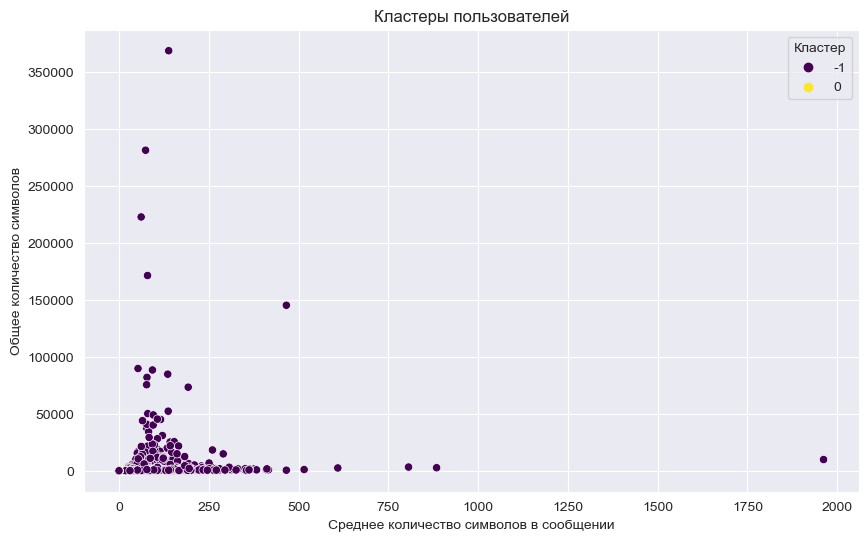

,sender_id,message_count,avg_char_count,total_char_count,avg_word_count,total_word_count,avg_photo,total_photo,avg_video,total_video,...,avg_is_reply,total_is_reply,is_active,most_active_hour,neutral_messages,1star_messages,2star_messages,3star_messages,4star_messages,5star_messages
cluster,,,,,,,,,,,,,,,,,,,,,
-1,2003,25.288567,72.537942,2192.873689,10.687749,324.796306,0.044466,1.670994,0.001891,0.040439,...,0.196553,10.391912,0.158263,11.932102,1.968048,8.686970,2.076385,4.079880,2.628058,5.849226
0,3025,1.072397,0.399364,1.228430,0.066754,0.205620,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,12.394050,1.009917,0.012893,0.000992,0.008926,0.004628,0.035041


In [43]:
# Стандартизация данных
scaler = StandardScaler()
features_scaled = scaler.fit_transform(user_features.drop(columns=['sender_id','first_message_date','last_message_date']))

# Выполнение кластеризации с использованием DBSCAN
db = DBSCAN(eps=0.5, min_samples=100).fit(features_scaled)
user_features['cluster'] = db.labels_

# Визуализация кластеров
plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_char_count', y='total_char_count', hue='cluster', data=user_features, palette='viridis')
plt.title('Кластеры пользователей')
plt.xlabel('Среднее количество символов в сообщении')
plt.ylabel('Общее количество символов')
plt.legend(title='Кластер')
plt.show()

# Вывод характеристик кластеров
cluster_summary = user_features.groupby('cluster').mean()
cluster_summary2= user_features.groupby('cluster').agg({
    'sender_id': 'count',})
cluster_summary['sender_id'] = cluster_summary2['sender_id']
cluster_summary

In [39]:
# Объединяем `data` и `user_features` по `sender_id`
data_with_clusters = data.merge(user_features[['sender_id', 'cluster']], on='sender_id', how='left')
data_with_clusters.to_csv('data/data_with_clusters.csv', index=False)
user_features.to_csv('data/user_data.csv', index=False)